# Empiric tests
### noise variance

INFO:speechbrain.utils.quirks:Applied quirks (see `speechbrain.utils.quirks`): [allow_tf32, disable_jit_profiling]
INFO:speechbrain.utils.quirks:Excluded quirks specified by the `SB_DISABLE_QUIRKS` environment (comma-separated list): []
/tmp/ipykernel_1350060/646531109.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any 

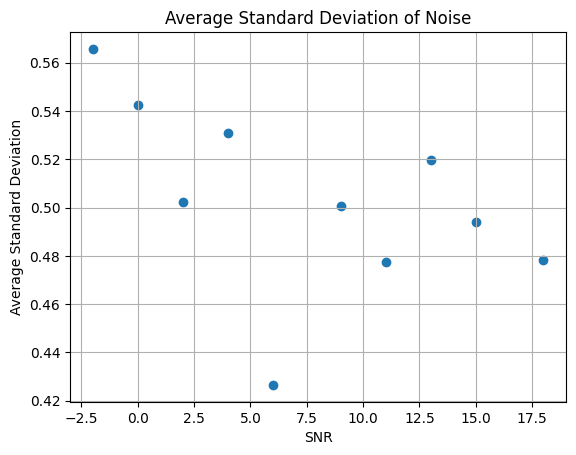

In [2]:
import torch
import matplotlib.pyplot as plt
from src.callbacks.metrics import calculate_curvature_displacement

samples = torch.load('test_results/noise_variance.pt')
samples : dict[int, torch.Tensor]

snr_levels = list(samples.keys())
avg_std_devs = []

for snr, batch in samples.items():
    batch = batch.reshape(batch.shape[0], -1)
    avg_std_dev = batch.std(dim=0).mean().item()
    avg_std_devs.append(avg_std_dev)
    
plt.scatter(snr_levels, avg_std_devs)
plt.title('Average Standard Deviation of Noise')
plt.xlabel('SNR')
plt.ylabel('Average Standard Deviation')
plt.grid()
plt.savefig('figures/average_std_dev.png')
plt.show()


### Curvature

INFO:speechbrain.utils.quirks:Applied quirks (see `speechbrain.utils.quirks`): [allow_tf32, disable_jit_profiling]
INFO:speechbrain.utils.quirks:Excluded quirks specified by the `SB_DISABLE_QUIRKS` environment (comma-separated list): []
/tmp/ipykernel_1543463/2377032508.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any

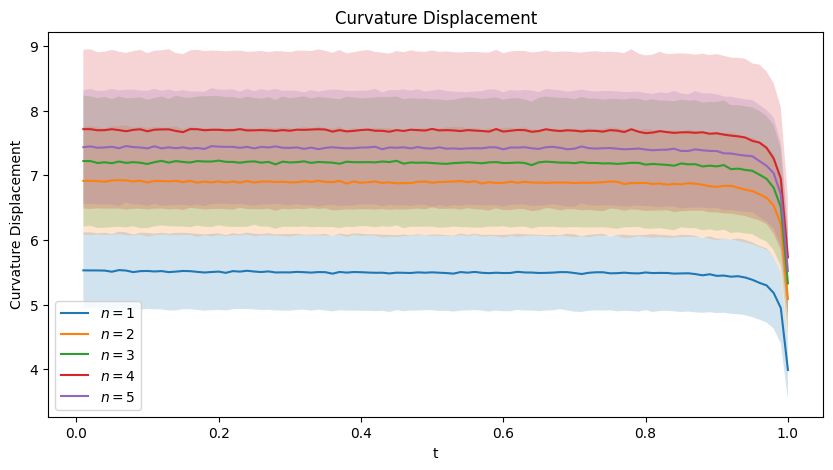

In [1]:
import torch
import matplotlib.pyplot as plt
from src.callbacks.metrics import calculate_curvature_displacement

trajectories : dict[int, torch.Tensor] = torch.load('test_results/trajectory_curvature.pt')
timeschedule = trajectories.pop('timeschedule')
dsb_iterations = list(trajectories.keys())
percentile_factor = 0.6745 # 25th percentile of a normal distribution

plt.figure(figsize=(10, 5))
for dsb_iteration in dsb_iterations:
    trajectory = trajectories[dsb_iteration]
    C_t = calculate_curvature_displacement(trajectory, timeschedule)
    C_t_mean = C_t.mean(dim=0)
    C_t_std = C_t.std(dim=0)
    plt.plot(timeschedule[1:], C_t_mean, label=rf'$n={dsb_iteration}$')
    plt.fill_between(timeschedule[1:], C_t_mean - percentile_factor * C_t_std, C_t_mean + percentile_factor * C_t_std, alpha=0.2)

plt.title('Curvature Displacement')
plt.xlabel('t')
plt.legend()
plt.ylabel('Curvature Displacement')
plt.show()

In [48]:
from src.networks import STFTEncoderDecoder
import torch

seconds = 2.075
audio = torch.randn(1, 1, int(16_000 * seconds))
encoder = STFTEncoderDecoder(n_fft=510, hop_length=128)
spec = encoder.encode(audio)
print(spec.shape)

torch.Size([1, 2, 256, 256])


In [7]:
from src.networks import OpenSoundEncoder
import torch

seconds = 0.64
sample_length = int(16_000 * seconds)   
audio = torch.randn(1, 1, sample_length)
encoder = OpenSoundEncoder()
encoded = encoder.encode(audio)
print(encoded.shape)


Loading OpenSound VAE...
No module named 'flash_attn'
flash_attn not installed, disabling Flash Attention


/work3/s214630/Latent-DSB/.venv/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:134: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


torch.Size([1, 128, 32])
